# ELMo and BERT Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo/BERT to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import random
import scipy.stats

import src.corpus
import src.semantic_embedding

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Parse the corpus

In [2]:
#UD_PATH = '../data/ud_all/ud-treebanks-v2.5/'
#ud_files = src.corpus.group_treebanks_by_language(UD_PATH)
#corpus = src.corpus.POSCorpus.create_from_ud(data_file_list=ud_files['English'])

BNC_FILE = "../data/bnc/bnc.pkl"
corpus = src.corpus.POSCorpus.create_from_pickle(data_file_path=BNC_FILE)

## Compute embeddings on random part of the corpus

In [3]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 1.0
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])
  
embedder = src.semantic_embedding.SemanticEmbedding(sampled_sentences)
embedder.init_bert(model_name='bert-base-uncased', layer=12)

## Compute embeddings of instances of a fixed lemma

In [4]:
FIXED_LEMMA = "ring"
noun_embeddings, verb_embeddings, noun_indices, verb_indices = embedder.get_bert_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Processing lemma: ring (538 instances)
Noun instances: 167
Verb instances: 370


## Apply PCA and plot

In [5]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)
all_embeddings_df['sentence_ix'] = noun_indices + verb_indices

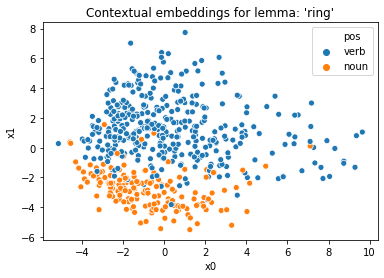

In [6]:
plot = sns.scatterplot(data=all_embeddings_df.sample(frac=1), x='x0', y='x1', hue='pos')
plot.set(title="Contextual embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what it's capturing

## Cosine similarity between noun and verb usages

In [7]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 30) & (lemma_count_df['verb_count'] >= 30)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
#lemma_count_df = lemma_count_df[~lemma_count_df.lemma.isin(['go', 'will', 'may'])]
print('Remaining lemmas:', len(lemma_count_df))
print('Noun lemmas:', len(lemma_count_df[lemma_count_df.majority_tag == 'NOUN']))
print('Verb lemmas:', len(lemma_count_df[lemma_count_df.majority_tag == 'VERB']))

Remaining lemmas: 320
Noun lemmas: 172
Verb lemmas: 148


In [8]:
lemma_count_df[['nv_cosine_similarity', 'n_variation', 'v_variation']] = \
  lemma_count_df.apply(lambda row: embedder.get_contextual_nv_similarity(row.lemma, method="bert"),
                       axis=1, result_type="expand")

Processing lemma: go (13010 instances)
Processing lemma: will (11002 instances)
Processing lemma: can (10564 instances)
Processing lemma: look (6310 instances)
Processing lemma: time (5127 instances)
Processing lemma: use (3366 instances)
Processing lemma: work (3082 instances)
Processing lemma: may (2821 instances)
Processing lemma: need (2811 instances)
Processing lemma: leave (2095 instances)
Processing lemma: point (1901 instances)
Processing lemma: place (1933 instances)
Processing lemma: show (1927 instances)
Processing lemma: hand (1826 instances)
Processing lemma: house (1804 instances)
Processing lemma: sort (1736 instances)
Processing lemma: turn (1753 instances)
Processing lemma: call (1726 instances)
Processing lemma: change (1644 instances)
Processing lemma: form (1534 instances)
Processing lemma: face (1399 instances)
Processing lemma: head (1445 instances)
Processing lemma: start (1394 instances)
Processing lemma: talk (1369 instances)
Processing lemma: end (1363 instanc

In [9]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity', 'n_variation', 'v_variation']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity,n_variation,v_variation
227,will,147,12273,VERB,0.692228,9.414062,11.370583
6955,peer,35,73,VERB,0.705469,9.568041,8.946688
11669,sue,39,66,VERB,0.729115,9.828123,8.883540
859,may,92,2954,VERB,0.760536,10.374884,9.914226
11221,store,95,158,VERB,0.767620,9.070530,7.614118
3954,screen,107,31,NOUN,0.771846,9.107773,8.531034
3076,amount,236,76,NOUN,0.778677,8.712680,8.914835
1216,wave,402,120,NOUN,0.781862,8.619149,9.333996


In [10]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity', 'n_variation', 'v_variation']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity,n_variation,v_variation
2554,sleep,171,291,VERB,0.963639,8.814505,8.931989
23909,overflow,154,42,NOUN,0.957122,7.971982,9.386598
2454,drink,456,315,NOUN,0.951716,8.819073,8.906000
257,play,185,1093,VERB,0.949657,8.931941,9.062548
5865,love,495,573,VERB,0.948797,9.140776,9.097881
406,work,1665,1593,NOUN,0.948661,9.187344,9.375356
2242,test,273,126,NOUN,0.948371,8.644535,8.524606
2008,equal,47,38,NOUN,0.948102,8.589618,8.779578


## Difference in similarity when base is noun vs verb

/h/bai/moar/bai-conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


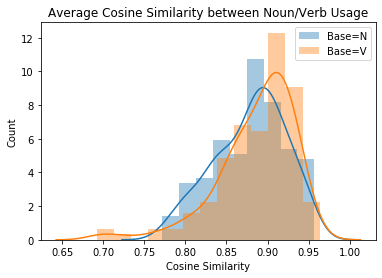

In [11]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [12]:
print('Mean cosine similarity when Base=N:', np.mean(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity))
print('Mean cosine similarity when Base=V:', np.mean(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity))

Mean cosine similarity when Base=N: 0.8787201691505521
Mean cosine similarity when Base=V: 0.8864951524380091


In [13]:
# T-test of difference in mean
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=-1.5297110129391849, pvalue=0.12708238385604045)

## Difference in variation between majority and minority class

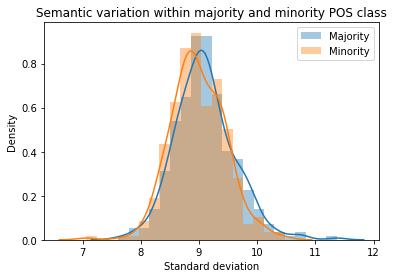

In [14]:
majority_variation = np.where(lemma_count_df.majority_tag == 'NOUN', lemma_count_df.n_variation, lemma_count_df.v_variation)
minority_variation = np.where(lemma_count_df.majority_tag == 'NOUN', lemma_count_df.v_variation, lemma_count_df.n_variation)
plot = sns.distplot(majority_variation, label='Majority')
plot = sns.distplot(minority_variation, label='Minority')
plt.legend()
plot.set(title="Semantic variation within majority and minority POS class",
         xlabel="Standard deviation", ylabel="Density")
plt.show()

In [15]:
print('Mean majority variation:', np.mean(majority_variation))
print('Mean minority variation:', np.mean(minority_variation))

Mean majority variation: 9.10008724629879
Mean minority variation: 8.988409443199634


In [16]:
# Paired t-test for difference
scipy.stats.ttest_rel(majority_variation, minority_variation)

Ttest_relResult(statistic=3.4928622827626077, pvalue=0.0005453362987705957)